In [26]:
import pandas as pd
import numpy as np

In [27]:
# import umap
# import umap.plot

In [28]:
import pickle

In [29]:
from sklearn.decomposition import LatentDirichletAllocation

In [30]:
from sklearn.mixture import GaussianMixture

In [31]:
from sklearn.metrics import silhouette_score

In [32]:
import matplotlib.pyplot as plt
import numpy as np

In [33]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [34]:
class Sampling(layers.Layer):

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))

        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_MSE_tracker = keras.metrics.Mean(
            name="reconstruction_loss_MSE"
        )
        self.reconstruction_loss_binary_tracker = keras.metrics.Mean(
            name="reconstruction_loss_binary"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_MSE_tracker,
            self.reconstruction_loss_binary_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss_MSE = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.MeanSquaredError()(data[:,0:2], reconstruction[:,0:2])
                )
            )
            reconstruction_loss_binary = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.BinaryCrossentropy()(data[:,2:], reconstruction[:,2:])
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            # total_loss = 0.2*reconstruction_loss_MSE + 0.4*reconstruction_loss_binary + 0.4*kl_loss
            total_loss = reconstruction_loss_MSE + reconstruction_loss_binary + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_MSE_tracker.update_state(reconstruction_loss_MSE)
        self.reconstruction_loss_binary_tracker.update_state(reconstruction_loss_binary)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss_MSE": self.reconstruction_loss_MSE_tracker.result(),
            "reconstruction_loss_binary": self.reconstruction_loss_binary_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [35]:
def get_user_history(df):
    gr = df.groupby(['order_requests', 'avatar_id'])

    new_df = pd.DataFrame()
    for _, v in gr:
        new_df = new_df.append(v.head(1)[['order_requests', 'avatar_id']])
    new_df['user_history'] = new_df.groupby('avatar_id').cumcount()

    df = pd.merge(df, new_df, how='inner', on=['order_requests', 'avatar_id'])

    return df

In [36]:
def map_hotel_group(group):
    groups = {'Boss Western': 'Boss_Western_Group', 'Accar Hotels': 'Accar_Hotels', 'Independant': 'Independant_Group',
              'Yin Yang': 'Yin_Yang', 'Chillton Worldwide': 'Chillton_Worldwide',
              'Morriott International': 'Morriott_International'}

    return groups[group]

def map_hotel_brand(brand):
    brands = {'J.Halliday Inn': 'J_Halliday_Inn', 'Marcure': 'Marcure', 'Independant': 'Independant_Brand',
              'Ibas': 'Ibas', 'Safitel': 'Safitel', '8 Premium': '8_Premium', 'Tripletree': 'Tripletree',
              'CourtYord': 'CourtYord', 'Royal Lotus': 'Royal_Lotus', 'Boss Western': 'Boss_Western_Brand',
              'Corlton': 'Corlton', 'Navatel': 'Navatel', 'Ardisson': 'Ardisson', 'Morriot': 'Morriot',
              'Chill Garden Inn': 'Chill_Garden_Inn', 'Quadrupletree': 'Quadrupletree'}

    return brands[brand]

def load_full_feature_set():
    # load data
    queries = pd.read_csv('all_queries.csv')
    prices = pd.read_csv('all_prices.csv')
    hotels = pd.read_csv('features_hotels.csv')
    test = pd.read_csv('test_set.csv')

    # drop query duplicates
    # queries = queries.drop_duplicates(subset=['language', 'city', 'date', 'mobile'])
    queries = queries.rename(columns={'queryId': 'order_requests'})
    prices = prices.rename(columns={'queryId': 'order_requests'})
    # queries = get_user_history(queries)

    ### X_TRAIN ###
    # merge queries, prices and hotel_features
    X_train = pd.merge(queries, prices, how='inner', on='order_requests')
    X_train = pd.merge(X_train, hotels, how='inner', on='hotel_id')
    X_train = X_train.drop(columns='city_y')
    X_train = X_train.rename(columns={'city_x': 'city'})

    # brand and group correction
    X_train['brand'] = X_train.apply(lambda x: map_hotel_brand(x['brand']), axis=1)
    X_train['group'] = X_train.apply(lambda x: map_hotel_group(x['group']), axis=1)

    X_train = X_train.drop(columns=['avatar_name'])
    
    # feature ordering to match test set
    X_train = X_train[['order_requests', 'avatar_id', 'city', 'language', 'date', 'mobile',
                       # 'user_history',
                       'stock', 'group', 'brand', 'parking', 'pool', 'hotel_id',
                       'children_policy', 'price']]
    ### X_TRAIN ###
    
    
    ### X_TEST ###
    # merge test_set with hotel_features
    # test = get_user_history(test)
    X_test = pd.merge(test, hotels, how='inner', on='hotel_id')
    X_test = X_test.drop(columns='city_y')
    X_test = X_test.rename(columns={'city_x': 'city'})

    # brand and group correction
    X_test['brand'] = X_test.apply(lambda x: map_hotel_brand(x['brand']), axis=1)
    X_test['group'] = X_test.apply(lambda x: map_hotel_group(x['group']), axis=1)

    X_test = X_test[['index', 'order_requests', 'avatar_id', 'city', 'language', 'date', 'mobile',
                     # 'user_history',
                     'stock', 'group', 'brand', 'parking', 'pool', 'hotel_id',
                     'children_policy']]
    ### X_TEST ###
    
    return X_train, X_test

In [37]:
X_train, X_test = load_full_feature_set()

X_train = X_train.set_index(['order_requests', 'avatar_id', 'hotel_id'])
X_test = X_test.set_index(['order_requests', 'avatar_id', 'hotel_id'])

y_train = X_train.pop('price')
test_idxs = X_test.pop('index')

In [38]:
categories = ['city', 'language', 'mobile', 'group', 'brand', 'parking', 'pool', 'children_policy']

X_train = pd.get_dummies(X_train, columns=categories)
X_test = pd.get_dummies(X_test, columns=categories)

In [39]:
X = X_train.sample(200000, random_state=0)
# X = X_train.copy()

In [40]:
X_index = X.index

In [41]:
input_dim = X.shape[1]
latent_dim = 2

######################################################
# Encoder Architecture
######################################################
encoder_inputs = keras.Input(shape=input_dim)
x = layers.Dense(64, activation=tf.nn.leaky_relu, kernel_initializer='glorot_normal', bias_initializer='zeros')(encoder_inputs)
x = layers.Dense(32, activation=tf.nn.leaky_relu, kernel_initializer='glorot_normal', bias_initializer='zeros')(x)
x = layers.Dense(16, activation=tf.nn.leaky_relu, kernel_initializer='glorot_normal', bias_initializer='zeros')(x)
x = layers.Dense(12, activation=tf.nn.leaky_relu, kernel_initializer='glorot_normal', bias_initializer='zeros')(x)
######################################################
# Sampling Layer
######################################################
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

######################################################
# Decoder Architecture
######################################################
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(12, activation=tf.nn.leaky_relu, kernel_initializer='glorot_normal', bias_initializer='zeros')(latent_inputs)
x = layers.Dense(16, activation=tf.nn.leaky_relu, kernel_initializer='glorot_normal', bias_initializer='zeros')(x)
x = layers.Dense(32, activation=tf.nn.leaky_relu, kernel_initializer='glorot_normal', bias_initializer='zeros')(x)
x = layers.Dense(64, activation=tf.nn.leaky_relu, kernel_initializer='glorot_normal', bias_initializer='zeros')(x)
x1 = x[:,0:2]
x2 = x[:,2:]
x1 = layers.Dense(2, activation='relu')(x1)
x2 = layers.Dense(input_dim-2, activation='sigmoid')(x2)

decoder_outputs = tf.concat([x1, x2], 1)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 69)]         0           []                               
                                                                                                  
 dense_10 (Dense)               (None, 64)           4480        ['input_3[0][0]']                
                                                                                                  
 dense_11 (Dense)               (None, 32)           2080        ['dense_10[0][0]']               
                                                                                                  
 dense_12 (Dense)               (None, 16)           528         ['dense_11[0][0]']               
                                                                                            

In [42]:
vae = VAE(encoder, decoder)
# vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001, clipnorm=1.0))
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))
vae.fit(X, epochs=100, batch_size=64)

Z_mean, Z_log_var, Z = vae.encoder.predict(X)

print("latent variables are ready to used")

Epoch 1/100
3125/3125 [==============================] - 11s 3ms/step - loss: 2667.0171 - reconstruction_loss_MSE: 98.6618 - reconstruction_loss_binary: 0.2760 - kl_loss: 285.9148
Epoch 2/100
3125/3125 [==============================] - 9s 3ms/step - loss: 13.9159 - reconstruction_loss_MSE: 5.9345 - reconstruction_loss_binary: 0.2551 - kl_loss: 6.0704
Epoch 3/100
3125/3125 [==============================] - 9s 3ms/step - loss: 8.8954 - reconstruction_loss_MSE: 2.9189 - reconstruction_loss_binary: 0.2519 - kl_loss: 5.1476
Epoch 4/100
3125/3125 [==============================] - 9s 3ms/step - loss: 7.1389 - reconstruction_loss_MSE: 1.8135 - reconstruction_loss_binary: 0.2499 - kl_loss: 4.8431
Epoch 5/100
3125/3125 [==============================] - 9s 3ms/step - loss: 6.5335 - reconstruction_loss_MSE: 1.5812 - reconstruction_loss_binary: 0.2490 - kl_loss: 4.6367
Epoch 6/100
3125/3125 [==============================] - 9s 3ms/step - loss: 6.3598 - reconstruction_loss_MSE: 1.5873 - reconst

In [43]:
Z

array([[ 0.21606563,  0.89093447],
       [ 0.48857272, -1.363517  ],
       [-0.6114145 , -1.4238306 ],
       ...,
       [ 0.6577572 , -0.88275415],
       [ 1.2993548 , -0.02720215],
       [-0.8230093 , -0.3834681 ]], dtype=float32)

In [44]:
Z.shape

(200000, 2)

In [45]:
Z_mean

array([[ 0.45350188,  0.89225996],
       [-0.2829879 , -0.9948838 ],
       [-0.0628404 , -1.383019  ],
       ...,
       [ 0.42585784, -0.8359037 ],
       [ 1.2828965 , -0.04952901],
       [-0.61872566, -0.28220257]], dtype=float32)

In [46]:
Z_log_var

array([[-2.9195852 , -8.944084  ],
       [-0.33387542, -3.049738  ],
       [-0.05190957, -2.2410421 ],
       ...,
       [-0.4200604 , -3.4694307 ],
       [-2.4491873 , -7.3564086 ],
       [-2.3889952 , -5.396973  ]], dtype=float32)

In [47]:
from sklearn.cluster import KMeans

2 0.31766754
5 0.33651617
6 0.3382763
10 0.3205834
16 0.33339486


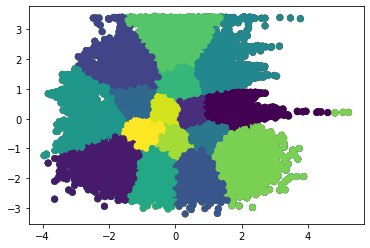

In [48]:
for n_components in [2,5,6,10,16]:
    kmeans = KMeans(n_clusters=n_components, init='k-means++', n_init=100, max_iter=10000, tol=0.0001, verbose=0, random_state=0).fit(Z)
    labels = kmeans.predict(Z)
    print(n_components, silhouette_score(Z, labels))
    plt.scatter(Z[:,0], Z[:,1], c=labels)
    figname = 'vae_clusters_' + str(n_components) + '.png'
    plt.savefig(figname)

In [49]:
np.save('2d/Z_2d.npy', Z)

In [50]:
np.save('2d/Z_mean_2d.npy', Z_mean)

In [51]:
np.save('2d/Z_log_var_2d.npy', Z_log_var)

In [52]:
X.to_csv('2d/reduced_original_data.csv')

In [53]:
Z_df = pd.DataFrame(data=Z, index=X_index)

In [54]:
Z_df.to_csv('2d/Z_2d_df.csv')